In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from skbio.stats.composition import closure, ilr, inner, _gram_schmidt_basis  # normalizes samples to add to 1.
from skbio import TreeNode, DistanceMatrix
from scipy.cluster.hierarchy import average
from gneiss.balances import balanceplot, balance_basis
from ete3 import Tree
%matplotlib inline

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


We'll start off using balance trees on the false positive data sets that we simulated previously in `part3_differential_abundance_benchmarks.ipynb`


In [2]:
D = 1000   # number of species
S = 10     # number of different samples
N = 10000  # sequencing depth
R = 30     # number of replicates
otu_ids = ["O%d"%i for i in range(D)]
sample_ids = ["S%d"%i for i in range(S)]
data = [[1000]*D]
for a in np.logspace(0, 5, S-1):
    data.append([1000*a] + [1000]*(D-1))
table = pd.DataFrame(data, columns=otu_ids, index=sample_ids)

In this particular scenario, we want to have a tree that can represent the balance between the very first species and the other species. To this, we will represent the balances using a tree.  This tree will be generated using UPGMA, using a reciprocal differences.

In [3]:
# The distance metric
d_metric = lambda x, y: ((1. / (x+1)) - (1. / (y+1)))**2
ranks = pd.Series(range(D), index=otu_ids) 

# Build distance matrix
dm = DistanceMatrix.from_iterable(ranks.values, metric=d_metric)
dm.ids = otu_ids

# Generate hierarchical clustering
lm = average(dm.condensed_form())

# build tree from clustering
tree = TreeNode.from_linkage_matrix(lm, otu_ids)

# estimate the balanace basis
basis, nodes = balance_basis(tree) 

Now, we will be running the same simulations as the previous notebook.  But instead of testing the individual
the individual proportions, we'll be testing the individual balances.  And we'll be testing for number of significant balances.  In essence, there should only be 1 significant balance - `O0` versus all of the other species.

In [4]:
fdr = [] 
for i in range(1, S):
    sample1 = np.random.multinomial(N, closure(table.iloc[0, :].values), size=R)
    sample2 = np.random.multinomial(N, closure(table.iloc[i, :].values), size=R)
    ilr_sample1 = ilr(sample1+1, basis=basis)
    ilr_sample2 = ilr(sample2+1, basis=basis)
    t, p = scipy.stats.ttest_ind(ilr_sample1, ilr_sample2)
    fdr.append((p<0.05).sum())

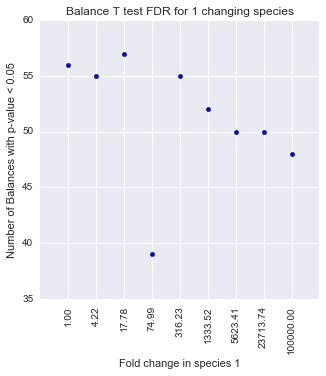

In [5]:
fig = plt.figure(figsize=(5, 5))
x = range(i)
plt.scatter(x, fdr)
labels = np.logspace(0, 5, S-1)
labels = ["%.2f" % a for a in labels]
_ = plt.xticks(x, labels, rotation=90)
plt.ylabel('Number of Balances with p-value < 0.05')
plt.xlabel('Fold change in species 1')
plt.title('Balance T test FDR for 1 changing species')

From here, it is apparent that we have more than 1 significant balance.  But this is much more sane compared to the benchmark in the previous notebook.  The number of significant species has leveled off around 50-60 species.

In this benchmark, we were using some prior knowledge that `O0` grouped differently from all of the other balances.  Let's see what happens if we use the default topology provided in `skbio.stats.composition.ilr`

In [6]:
fdr = [] 
for i in range(1, S):
    sample1 = np.random.multinomial(N, closure(table.iloc[0, :].values), size=R)
    sample2 = np.random.multinomial(N, closure(table.iloc[i, :].values), size=R)
    ilr_sample1 = ilr(sample1+1)
    ilr_sample2 = ilr(sample2+1)
    t, p = scipy.stats.ttest_ind(ilr_sample1, ilr_sample2)
    fdr.append((p<0.05).sum())

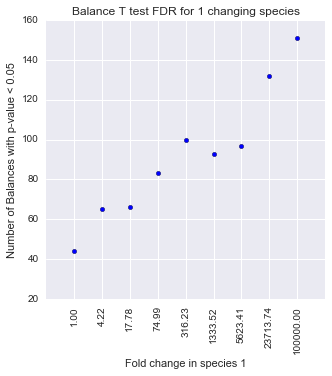

In [7]:
fig = plt.figure(figsize=(5, 5))
x = range(i)
plt.scatter(x, fdr)
labels = np.logspace(0, 5, S-1)
labels = ["%.2f" % a for a in labels]
_ = plt.xticks(x, labels, rotation=90)
plt.ylabel('Number of Balances with p-value < 0.05')
plt.xlabel('Fold change in species 1')
plt.title('Balance T test FDR for 1 changing species')

So here, we have a trend that is linear with respect to the fold change in species 1.  While at first glance, this may appear to be wrong, it actually makes sense.

The default topology in `skbio.stats.composition.ilr` is actually the reversed tree that was calculated in the first step.  So the most significant balance also corresponded to the internal node that is the deepest in the node.  So the more that Species 1 increases, the more balances higher up the tree get significantly changed.

This isn't a wrong analysis, but it does provide a different perspective on the same dataset.  In short, getting a useful tree topology is important to get interpretatable results.